In [6]:
# --- CELDA 1: IMPORTACIONES Y CARGA ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)

# Configuración de carpetas
results_folder = "Resultados"
predictions_folder = "Predicciones"
figures_folder = "Figuras"

# Crear carpeta de figuras si no existe
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

# Cargar los resultados de los modelos base (generados en eval.ipynb)
base_results_path = os.path.join(results_folder, "all_metrics_raw.csv")

if os.path.exists(base_results_path):
    df_base = pd.read_csv(base_results_path)
    print(f"✅ Resultados base cargados correctamente: {len(df_base)} registros.")
else:
    raise FileNotFoundError("❌ No se encuentra 'all_metrics_raw.csv'. Debes ejecutar eval.ipynb primero.")

✅ Resultados base cargados correctamente: 180 registros.


In [7]:
# --- CELDA 2: FUNCIONES PARA ENSEMBLES ---

def calculate_metrics(y_true, y_pred, y_proba=None):
    """Calcula métricas para los nuevos modelos de Ensemble"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Cálculos One-vs-All para multiclase
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Evitamos división por cero
    with np.errstate(divide='ignore', invalid='ignore'):
        Sensibilidad = TP / (TP + FN)
        Especificidad = TN / (TN + FP)
        FPR = FP / (FP + TN)
        FNR = FN / (TP + FN)
    
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "Sensitivity": np.nanmean(Sensibilidad),
        "Specificity": np.nanmean(Especificidad),
        "FPR": np.nanmean(FPR),
        "FNR": np.nanmean(FNR)
    }
    
    # AUC
    if y_proba is not None:
        try:
            if y_proba.shape[1] == 2:
                 auc_score = roc_auc_score(y_true, y_proba[:, 1])
            else:
                 auc_score = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        except:
            auc_score = 0.0
        metrics["AUC"] = auc_score
    else:
        metrics["AUC"] = 0.0
    
    return metrics

def get_ensemble_predictions(fold, dataset, methods_list):
    """Lee los CSVs de predicciones guardados y combina los resultados."""
    base_preds = []
    base_probas = []
    y_true = None
    
    for method in methods_list:
        filename = f"pred_{fold}_{dataset}_{method}.csv"
        filepath = os.path.join(predictions_folder, filename)
        
        if not os.path.exists(filepath):
            return None, None, None # Falta algún modelo, saltamos este fold
            
        df = pd.read_csv(filepath)
        if y_true is None:
            y_true = df['y_true'].values
        
        base_preds.append(df['y_pred'].values)
        
        # Extraer columnas de probabilidad (prob_0, prob_1, ...)
        proba_cols = [c for c in df.columns if c.startswith('prob_')]
        base_probas.append(df[proba_cols].values)

    return y_true, np.array(base_preds), np.array(base_probas)

In [8]:
# --- CELDA 3: CALCULAR Y UNIR ENSEMBLES ---

ensemble_results = []
datasets = df_base['Dataset'].unique()
folds = df_base['Fold'].unique()
methods_for_ensemble = ["knn", "svm", "nb", "rf"] 

print("Generando Ensembles (Votación, Media, Mediana)...")

for ds in datasets:
    for f in folds:
        y_true, preds_stack, probas_stack = get_ensemble_predictions(f, ds, methods_for_ensemble)
        
        if y_true is None:
            continue 
            
        # 1. VOTACIÓN (Moda/Mayoría)
        # mode devuelve [[moda], [conteo]], tomamos la moda [0]
        vote_pred = mode(preds_stack, axis=0)[0].ravel()
        # Aproximación de probabilidad para AUC (promedio)
        vote_proba = np.mean(probas_stack, axis=0) 
        
        m_vote = calculate_metrics(y_true, vote_pred, vote_proba)
        m_vote.update({'Fold': f, 'Dataset': ds, 'Method': 'Ensemble_Voting'})
        ensemble_results.append(m_vote)
        
        # 2. MEDIA (Promedio de probabilidades)
        mean_proba = np.mean(probas_stack, axis=0)
        mean_pred = np.argmax(mean_proba, axis=1)
        
        m_mean = calculate_metrics(y_true, mean_pred, mean_proba)
        m_mean.update({'Fold': f, 'Dataset': ds, 'Method': 'Ensemble_Mean'})
        ensemble_results.append(m_mean)
        
        # 3. MEDIANA (Mediana de probabilidades)
        median_proba = np.median(probas_stack, axis=0)
        median_pred = np.argmax(median_proba, axis=1)
        
        m_median = calculate_metrics(y_true, median_pred, median_proba)
        m_median.update({'Fold': f, 'Dataset': ds, 'Method': 'Ensemble_Median'})
        ensemble_results.append(m_median)

# Unir resultados base con resultados de ensemble
if ensemble_results:
    df_ensembles = pd.DataFrame(ensemble_results)
    df_final = pd.concat([df_base, df_ensembles], ignore_index=True)
    print(f"✅ Ensembles añadidos. Total de experimentos: {len(df_final)}")
else:
    print("⚠️ No se pudieron generar ensembles (¿faltan archivos de predicciones?).")
    df_final = df_base

Generando Ensembles (Votación, Media, Mediana)...
✅ Ensembles añadidos. Total de experimentos: 315


In [ ]:
# --- CELDA 4: CÁLCULO DE ESTADÍSTICAS (CORREGIDO) ---

# 1. Agrupar para obtener media y desviación
# Seleccionamos solo columnas numéricas para evitar errores
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.drop('Fold')
grouped = df_final.groupby(['Method', 'Dataset'])[numeric_cols].agg(['mean', 'std'])

# 2. Crear la tabla resumen formateada
# Creamos un DataFrame vacío con el mismo índice
summary_table = pd.DataFrame(index=grouped.index)

# Iteramos sobre cada métrica (Nivel 0 de las columnas: Accuracy, F1, etc.)
# y combinamos sus sub-columnas 'mean' y 'std'
for metric in grouped.columns.levels[0]:
    means = grouped[metric]['mean']
    stds = grouped[metric]['std']
    summary_table[metric] = means.map('{:.4f}'.format) + " ± " + stds.map('{:.4f}'.format)

# Guardar tabla cruda (útil para depurar)
grouped.to_csv(os.path.join(results_folder, "summary_statistics_raw.csv"))

print("Estadísticas calculadas y formateadas.")

Estadísticas calculadas y formateadas.


In [10]:
# --- CELDA 5: MOSTRAR Y GUARDAR TABLAS ---

# 1. Tabla Resumen General
print("--- Tabla Resumen General (Vista previa) ---")
display(summary_table.head())
summary_table.to_csv(os.path.join(results_folder, "table_general_latex_ready.csv"))

# 2. Tabla Pivot de F1-Score (Filas: Método, Cols: Dataset)
# Usamos la summary_table formateada, reseteamos el índice para poder pivotar
summary_reset = summary_table.reset_index()
f1_pivot = summary_reset.pivot(index='Method', columns='Dataset', values='F1-Score')

print("\n--- Tabla Resumen F1-Score ---")
display(f1_pivot)
f1_pivot.to_csv(os.path.join(results_folder, "table_f1_pivot.csv"))

--- Tabla Resumen General (Vista previa) ---


Accuracy            Precision  \
Method        Dataset                                                        
Ensemble_Mean estandarizado       0.9533 $\pm$ 0.0380  0.9572 $\pm$ 0.0365   
              estandarizadoPCA80  0.8933 $\pm$ 0.0596  0.9003 $\pm$ 0.0583   
              estandarizadoPCA95  0.8933 $\pm$ 0.0596  0.9003 $\pm$ 0.0583   
              normalizado         0.9533 $\pm$ 0.0380  0.9572 $\pm$ 0.0365   
              normalizadoPCA80    0.9467 $\pm$ 0.0380  0.9541 $\pm$ 0.0310   

                                               Recall             F1-Score  \
Method        Dataset                                                        
Ensemble_Mean estandarizado       0.9533 $\pm$ 0.0380  0.9531 $\pm$ 0.0382   
              estandarizadoPCA80  0.8933 $\pm$ 0.0596  0.8923 $\pm$ 0.0606   
              estandarizadoPCA95  0.8933 $\pm$ 0.0596  0.8923 $\pm$ 0.0606   
              normalizado         0.9533 $\pm$ 0.0380  0.9531 $\pm$ 0.0382   
              normalizadoPCA80    0.9467 $\pm$ 0.0380  0.9461 $\pm$ 0.0388   

                                          Sensitivity          Specificity  \
Method        Dataset                                                        
Ensemble_Mean estandarizado       0.9533 $\pm$ 0.0380  0.9767 $\pm$ 0.0190   
              estandarizadoPCA80  0.8933 $\pm$ 0.0596  0.9467 $\pm$ 0.0298   
              estandarizadoPCA95  0.8933 $\pm$ 0.0596  0.9467 $\pm$ 0.0298   
              normalizado         0.9533 $\pm$ 0.0380  0.9767 $\pm$ 0.0190   
              normalizadoPCA80    0.9467 $\pm$ 0.0380  0.9733 $\pm$ 0.0190   

                                                  FPR                  FNR  \
Method        Dataset                                                        
Ensemble_Mean estandarizado       0.0233 $\pm$ 0.0190  0.0467 $\pm$ 0.0380   
              estandarizadoPCA80  0.0533 $\pm$ 0.0298  0.1067 $\pm$ 0.0596   
              estandarizadoPCA95  0.0533 $\pm$ 0.0298  0.1067 $\pm$ 0.0596   
              normalizado         0.0233 $\pm$ 0.0190  0.0467 $\pm$ 0.0380   
              normalizadoPCA80    0.0267 $\pm$ 0.0190  0.0533 $\pm$ 0.0380   

                                                  AUC  
Method        Dataset                                  
Ensemble_Mean estandarizado       0.9967 $\pm$ 0.0033  
              estandarizadoPCA80  0.9810 $\pm$ 0.0182  
              estandarizadoPCA95  0.9810 $\pm$ 0.0182  
              normalizado         0.9980 $\pm$ 0.0030  
              normalizadoPCA80    0.9913 $\pm$ 0.0104


--- Tabla Resumen F1-Score ---


Dataset,estandarizado,estandarizadoPCA80,estandarizadoPCA95,normalizado,normalizadoPCA80,normalizadoPCA95,original,originalPCA80,originalPCA95
Method,,,,,,,,,
Ensemble_Mean,0.9531 $\pm$ 0.0382,0.8923 $\pm$ 0.0606,0.8923 $\pm$ 0.0606,0.9531 $\pm$ 0.0382,0.9461 $\pm$ 0.0388,0.9527 $\pm$ 0.0389,0.9665 $\pm$ 0.0238,0.9130 $\pm$ 0.0607,0.9665 $\pm$ 0.0335
Ensemble_Median,0.9531 $\pm$ 0.0382,0.8923 $\pm$ 0.0606,0.8923 $\pm$ 0.0606,0.9531 $\pm$ 0.0382,0.9530 $\pm$ 0.0300,0.9461 $\pm$ 0.0454,0.9665 $\pm$ 0.0238,0.9063 $\pm$ 0.0495,0.9598 $\pm$ 0.0280
Ensemble_Voting,0.9531 $\pm$ 0.0382,0.8994 $\pm$ 0.0529,0.8994 $\pm$ 0.0529,0.9531 $\pm$ 0.0382,0.9464 $\pm$ 0.0185,0.9597 $\pm$ 0.0282,0.9665 $\pm$ 0.0238,0.8995 $\pm$ 0.0623,0.9332 $\pm$ 0.0408
knn,0.9531 $\pm$ 0.0382,0.8983 $\pm$ 0.0634,0.8983 $\pm$ 0.0634,0.9531 $\pm$ 0.0382,0.9461 $\pm$ 0.0388,0.9528 $\pm$ 0.0388,0.9665 $\pm$ 0.0238,0.8925 $\pm$ 0.0496,0.9665 $\pm$ 0.0238
nb,0.9530 $\pm$ 0.0300,0.8925 $\pm$ 0.0366,0.8925 $\pm$ 0.0366,0.9530 $\pm$ 0.0300,0.9464 $\pm$ 0.0185,0.9125 $\pm$ 0.0452,0.9530 $\pm$ 0.0300,0.9330 $\pm$ 0.0532,0.8996 $\pm$ 0.0471
rf,0.9665 $\pm$ 0.0238,0.9057 $\pm$ 0.0733,0.9057 $\pm$ 0.0733,0.9598 $\pm$ 0.0280,0.9198 $\pm$ 0.0380,0.9530 $\pm$ 0.0300,0.9665 $\pm$ 0.0238,0.8863 $\pm$ 0.0606,0.9260 $\pm$ 0.0284
svm,0.9666 $\pm$ 0.0236,0.9127 $\pm$ 0.0511,0.9127 $\pm$ 0.0511,0.9598 $\pm$ 0.0436,0.9462 $\pm$ 0.0307,0.9598 $\pm$ 0.0280,0.9666 $\pm$ 0.0236,0.9129 $\pm$ 0.0506,0.9467 $\pm$ 0.0558


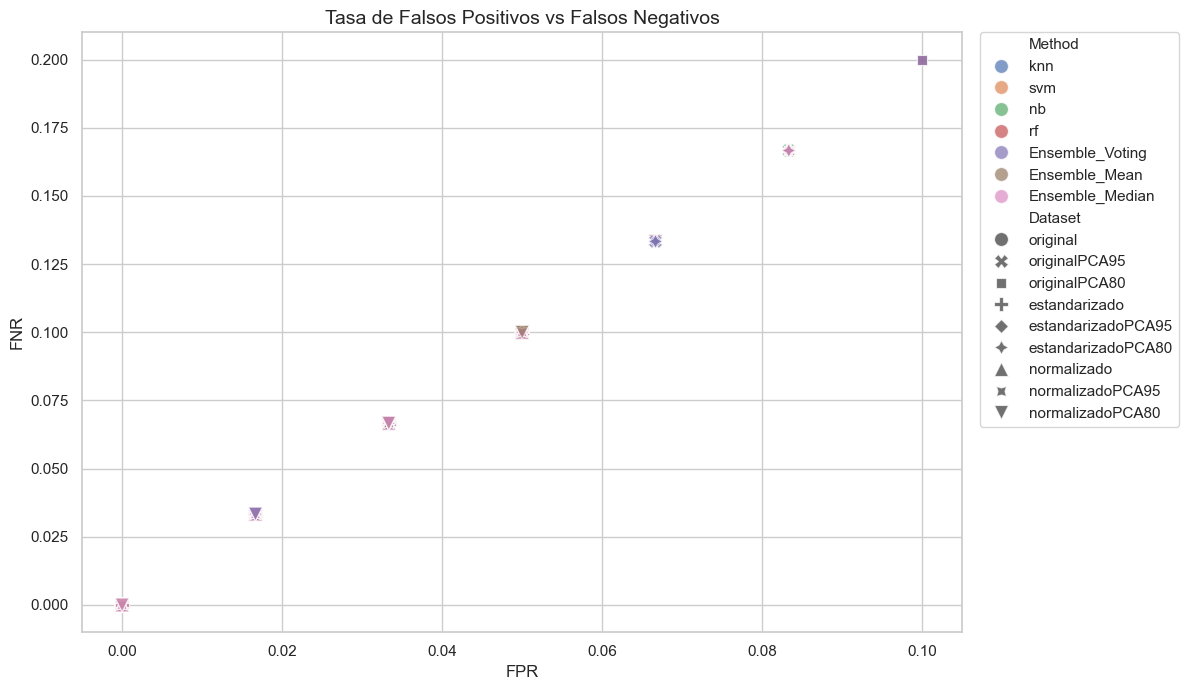

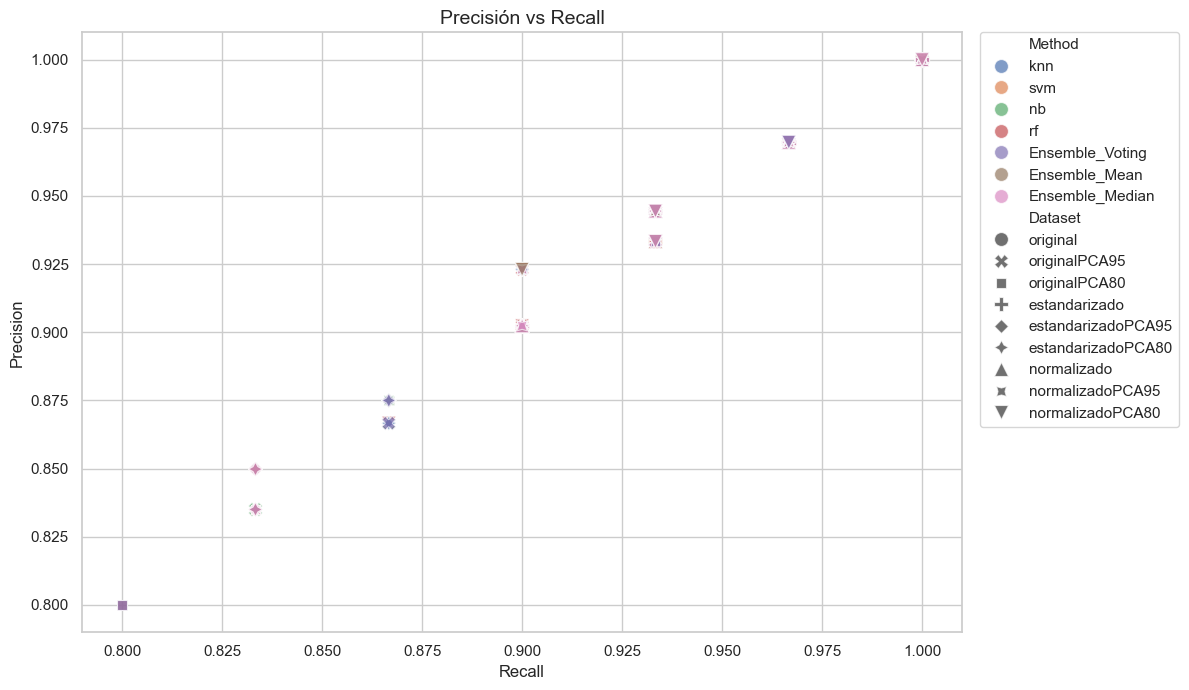

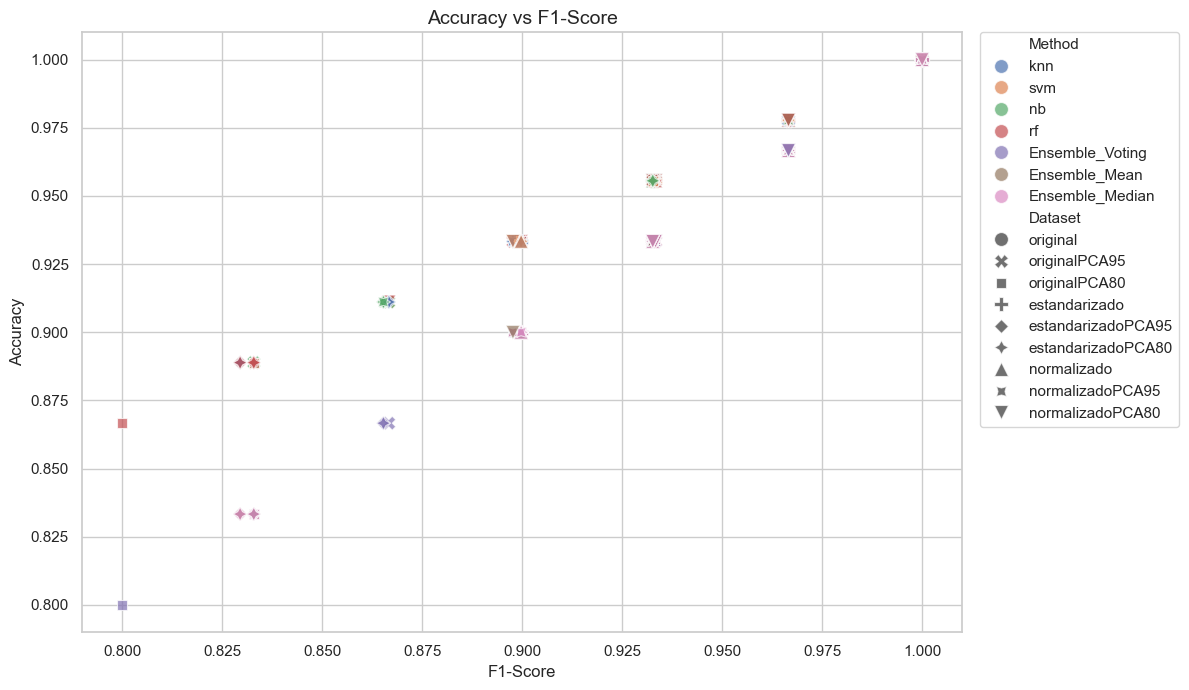

¡Gráficas generadas en 'Figuras/'!


In [11]:
# --- CELDA 6: GRÁFICAS CON SEABORN ---

# Configuración estética
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize':(12, 7), 'font.size': 10})

# Función auxiliar para plotear
def plot_metric(x, y, title, filename):
    plt.figure()
    sns.scatterplot(
        data=df_final, 
        x=x, 
        y=y, 
        hue='Method', 
        style='Dataset', 
        s=100, 
        alpha=0.7
    )
    plt.title(title, fontsize=14)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_folder, filename))
    plt.show()

# 1. FN contra FP
plot_metric('FPR', 'FNR', "Tasa de Falsos Positivos vs Falsos Negativos", "plot_FNR_vs_FPR.png")

# 2. Precision vs Recall
plot_metric('Recall', 'Precision', "Precisión vs Recall", "plot_Precision_vs_Recall.png")

# 3. Accuracy vs F1-Score
plot_metric('F1-Score', 'Accuracy', "Accuracy vs F1-Score", "plot_Acc_vs_F1.png")

print(f"¡Gráficas generadas en '{figures_folder}/'!")